In [1]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import DBSCAN
import folium
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
!gdown 17cHUkr4URd-B_isJjqaQ4MK5fW2mZ71q

Downloading...
From (original): https://drive.google.com/uc?id=17cHUkr4URd-B_isJjqaQ4MK5fW2mZ71q
From (redirected): https://drive.google.com/uc?id=17cHUkr4URd-B_isJjqaQ4MK5fW2mZ71q&confirm=t&uuid=56734587-0a85-4e7e-bd86-aeca391dac56
To: /content/cleaned_people.csv
100% 177M/177M [00:03<00:00, 57.2MB/s]


In [2]:
!gdown 1kYCWLYSsdVT6UxlFxHKPU_bRoeHAit5i

Downloading...
From (original): https://drive.google.com/uc?id=1kYCWLYSsdVT6UxlFxHKPU_bRoeHAit5i
From (redirected): https://drive.google.com/uc?id=1kYCWLYSsdVT6UxlFxHKPU_bRoeHAit5i&confirm=t&uuid=489f0f1a-0e9b-4bee-91d5-b33e68479143
To: /content/cleaned_crashes.csv
100% 127M/127M [00:01<00:00, 119MB/s]


In [10]:
crashes = pd.read_csv('/content/cleaned_crashes.csv')
people = pd.read_csv('/content/cleaned_people.csv')
# vehicles = pd.read_csv('/content/cleaned_vehicles.csv')

In [4]:
crashes['crash_date'] = pd.to_datetime(crashes['crash_date'])

In [11]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667725 entries, 0 to 667724
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   person_id              667725 non-null  object 
 1   person_type            667725 non-null  object 
 2   crash_record_id        667725 non-null  object 
 3   vehicle_id             653178 non-null  float64
 4   crash_date             667725 non-null  object 
 5   sex                    667725 non-null  object 
 6   age                    667725 non-null  float64
 7   safety_equipment       667725 non-null  object 
 8   airbag_deployed        667725 non-null  object 
 9   ejection               667725 non-null  object 
 10  injury_classification  667725 non-null  object 
 11  driver_action          667725 non-null  object 
 12  physical_condition     667725 non-null  object 
dtypes: float64(2), object(11)
memory usage: 66.2+ MB


In [13]:
people['physical_condition'].value_counts()

,count
physical_condition,
UNKNOWN,329972
NORMAL,328438
EMOTIONAL,1835
REMOVED BY EMS,1761
IMPAIRED - ALCOHOL,1711
OTHER,1577
FATIGUED/ASLEEP,1320
ILLNESS/FAINTED,438
HAD BEEN DRINKING,302


# Hien: dùng kịch bản
- Them: total injuries based on location
- Kịch bản 01: Phân Tích Nguyên Nhân Tai Nạn
- Kịch bản 03: Phân Tích Theo Thời Gian + average injuries theo giờ trong ngày
- Kịch bản 06: Lỗi Bề Mặt Đường và Mức Độ Tai Nạn

## Them: total injuries based on location

In [ ]:
high_injury_crashes = crashes[crashes['injuries_total'] > 0][['latitude', 'longitude', 'injuries_total']].dropna()

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.001, min_samples=27)
high_injury_crashes['cluster'] = dbscan.fit_predict(high_injury_crashes[['latitude', 'longitude']])

# Filter out noise points
clustered_data = high_injury_crashes[high_injury_crashes['cluster'] != -1]

# Aggregate data by cluster for circle marker sizing
cluster_summary = clustered_data.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'injuries_total': 'sum'
}).reset_index()

# Create a base map centered on Chicago
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add circle markers to the map
for _, row in cluster_summary.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['injuries_total'] / 10,  # Scale the radius based on total injuries
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"Cluster ID: {row['cluster']}<br>Total Injuries: {row['injuries_total']}"
    ).add_to(chicago_map)

# Save or display the map
# chicago_map.save('chicago_cluster_circle_markers.html')
chicago_map

In [ ]:
crashes['first_crash_type'].value_counts()

,count
first_crash_type,
PARKED MOTOR VEHICLE,69830
REAR END,60634
SIDESWIPE SAME DIRECTION,46042
TURNING,45330
ANGLE,33915
FIXED OBJECT,13929
PEDESTRIAN,7438
PEDALCYCLIST,5435
REAR TO FRONT,4789


In [ ]:
!python --version

Python 3.10.12


## Kịch bản 01: Phân Tích Nguyên Nhân Tai Nạn
**Kịch bản:** Phân tích mối quan hệ giữa PRIM_CONTRIBUTORY_CAUSE (Nguyên nhân chính), và FIRST_CRASH_TYPE (Loại tai nạn đầu tiên) để xác định nguyên nhân phổ biến nhất gây tai nạn.

**Thông tin rút ra:** Xác định các yếu tố chính góp phần gây tai nạn để có biện pháp an toàn cụ thể.

In [ ]:
for threshold_num in range(500,2001,100):
  print(f"threshold num: {threshold_num}")
  # Aggregating data for analysis
  analysis_df = (
      crashes.groupby(["prim_contributory_cause", "first_crash_type"])
      .size()
      .reset_index(name="count")
      .sort_values(by="count", ascending=False)
  )

  # Set threshold to exclude low-frequency data
  threshold = threshold_num  # Adjust as needed
  filtered_df = analysis_df[
      (analysis_df["count"] > threshold) &
      (~analysis_df["prim_contributory_cause"].isin(["UNABLE TO DETERMINE", "NOT APPLICABLE"]))
  ]

  # Stacked Bar Chart with swapped axes
  fig_bar = px.bar(
      filtered_df,
      x="count",
      y="prim_contributory_cause",
      color="first_crash_type",
      title="Crash Count by Primary Contributory Cause and First Crash Type (Excluding 'UNABLE TO DETERMINE' and 'NOT APPLICABLE')",
      labels={
          "prim_contributory_cause": "Primary Contributory Cause",
          "count": "Number of Crashes",
          "first_crash_type": "First Crash Type",
      },
      orientation="h",  # Horizontal bar chart
      barmode="stack",
  )

  fig_bar.show()

threshold num: 500


threshold num: 600


threshold num: 700


threshold num: 800


threshold num: 900


threshold num: 1000


threshold num: 1100


threshold num: 1200


threshold num: 1300


threshold num: 1400


threshold num: 1500


threshold num: 1600


threshold num: 1700


threshold num: 1800


threshold num: 1900


threshold num: 2000


In [ ]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302020 entries, 0 to 302019
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   crash_record_id          302020 non-null  object             
 1   crash_date               302020 non-null  datetime64[ns, UTC]
 2   posted_speed_limit       302020 non-null  int64              
 3   traffic_control_device   302020 non-null  object             
 4   device_condition         302020 non-null  object             
 5   weather_condition        302020 non-null  object             
 6   lighting_condition       302020 non-null  object             
 7   first_crash_type         302020 non-null  object             
 8   trafficway_type          302020 non-null  object             
 9   alignment                302020 non-null  object             
 10  roadway_surface_cond     302020 non-null  object             
 11  road_defect  

## Kịch bản 02: Tác Động của Thời Tiết và Bề Mặt Đường
**Kịch bản:** Nghiên cứu cách WEATHER_CONDITION (Điều kiện thời tiết), ROADWAY_SURFACE_COND (Điều kiện bề mặt đường), và ROAD_DEFECT (Lỗi bề mặt đường) ảnh hưởng đến FIRST_CRASH_TYPE (Loại tai nạn đầu tiên) và MOST_SEVERE_INJURY (Mức độ thương tích nghiêm trọng nhất).

**Thông tin rút ra:** Hiểu được tác động của điều kiện môi trường lên mức độ nghiêm trọng và loại tai nạn.

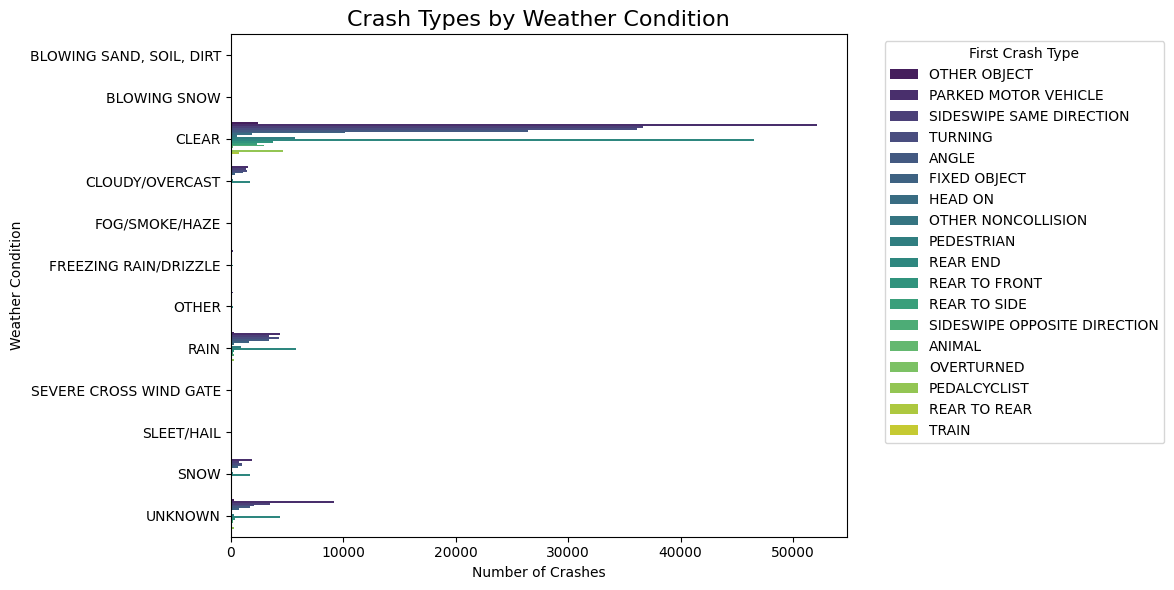

In [ ]:
# Group data by weather condition and first crash type
weather_crash_data = crashes.groupby(['weather_condition', 'first_crash_type']).size().reset_index(name='count')

# Group data by roadway surface condition and most severe injury
roadway_injury_data = crashes.groupby(['roadway_surface_cond', 'most_severe_injury']).size().reset_index(name='count')

# Group data by road defect and most severe injury
road_defect_injury_data = crashes.groupby(['road_defect', 'most_severe_injury']).size().reset_index(name='count')

# Plot crash types by weather condition
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weather_crash_data,
    x='count',
    y='weather_condition',
    hue='first_crash_type',
    palette='viridis'
)
plt.title('Crash Types by Weather Condition', fontsize=16)
plt.xlabel('Number of Crashes')
plt.ylabel('Weather Condition')
plt.legend(title='First Crash Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Kịch bản 03: Phân Tích Theo Thời Gian

**Kịch bản:** Xem xét các mô hình tai nạn dựa trên CRASH_HOUR (Giờ), CRASH_DAY_OF_WEEK (Ngày trong tuần), và CRASH_MONTH (Tháng) để xác định các thời điểm có nguy cơ cao.

**Thông tin rút ra:** Phát hiện các thời điểm cao điểm xảy ra tai nạn và triển khai các biện pháp phòng ngừa như tăng cường giám sát hoặc nâng cao nhận thức cộng đồng.

In [ ]:

# ---------------------- Hourly Data Aggregation ----------------------
# Calculate hourly injuries and crashes
injuries_hour_data = crashes.groupby("crash_hour", as_index=False).agg(
    injuries_total=("injuries_total", "sum")
)
crash_hour_data = crashes.groupby("crash_hour", as_index=False).agg(
    count=("crash_record_id", "count")
)

# Calculate average injuries per crash by hour
injuries_hour_data["avg_injuries_per_crash"] = (
    injuries_hour_data["injuries_total"] / crash_hour_data["count"]
)

# ---------------------- Visualization for Hourly Data ----------------------
# Combined plot for crashes and average injuries by hour
fig_hour_combined = go.Figure()

# Add bar plot for average injuries per crash by hour
fig_hour_combined.add_trace(
    go.Bar(
        x=injuries_hour_data["crash_hour"],
        y=injuries_hour_data["avg_injuries_per_crash"],
        name="Avg Injuries Per Crash",
        yaxis="y",
    )
)

# Add line plot for total crashes by hour
fig_hour_combined.add_trace(
    go.Scatter(
        x=crash_hour_data["crash_hour"],
        y=crash_hour_data["count"],
        mode="lines+markers",
        name="Total Crashes",
        yaxis="y2",
    )
)

# Layout settings for dual y-axes
fig_hour_combined.update_layout(
    title="Total Crashes and Average Injuries Per Crash by Hour of the Day",
    xaxis_title="Hour of the Day",
    yaxis=dict(title="Avg Injuries Per Crash"),
    yaxis2=dict(title="Crash Count", overlaying="y", side="right"),
)

fig_hour_combined.show()

In [ ]:
# ---------------------- Monthly Data Aggregation ----------------------
# Calculate monthly injuries and crashes
injuries_month_data = crashes.groupby("crash_month", as_index=False).agg(
    injuries_total=("injuries_total", "sum")
)
crash_month_data = crashes.groupby("crash_month", as_index=False).agg(
    count=("crash_record_id", "count")
)

# Calculate average injuries per crash by month
injuries_month_data["avg_injuries_per_crash"] = (
    injuries_month_data["injuries_total"] / crash_month_data["count"]
)

# ---------------------- Hourly Data Aggregation ----------------------
# Calculate hourly injuries and crashes
injuries_hour_data = crashes.groupby("crash_hour", as_index=False).agg(
    injuries_total=("injuries_total", "sum")
)
crash_hour_data = crashes.groupby("crash_hour", as_index=False).agg(
    count=("crash_record_id", "count")
)

# Calculate average injuries per crash by hour
injuries_hour_data["avg_injuries_per_crash"] = (
    injuries_hour_data["injuries_total"] / crash_hour_data["count"]
)

# Calculate average injuries per crash by month
injuries_month_data["avg_injuries_per_crash"] = (
    injuries_month_data["injuries_total"] / crash_month_data["count"]
)

# Combined plot for crashes and average injuries by month
fig_month_combined = go.Figure()

# Add bar plot for average injuries per crash by month
fig_month_combined.add_trace(
    go.Bar(
        x=injuries_month_data["crash_month"],
        y=injuries_month_data["avg_injuries_per_crash"],
        name="Avg Injuries Per Crash",
        yaxis="y",
    )
)

# Add line plot for total crashes by month
fig_month_combined.add_trace(
    go.Scatter(
        x=crash_month_data["crash_month"],
        y=crash_month_data["count"],
        mode="lines+markers",
        name="Total Crashes",
        yaxis="y2",
    )
)

# Layout settings for dual y-axes
fig_month_combined.update_layout(
    title="Crash Trends and Average Injuries Per Crash by Month",
    xaxis_title="Month",
    yaxis=dict(title="Avg Injuries Per Crash"),
    yaxis2=dict(title="Crash Count", overlaying="y", side="right"),
)

fig_month_combined.show()

# Calculate average injuries per crash by hour
injuries_hour_data["avg_injuries_per_crash"] = (
    injuries_hour_data["injuries_total"] / crash_hour_data["count"]
)

# Combined plot for crashes and average injuries by hour
fig_hour_combined = go.Figure()

# Add bar plot for average injuries per crash by hour
fig_hour_combined.add_trace(
    go.Bar(
        x=injuries_hour_data["crash_hour"],
        y=injuries_hour_data["avg_injuries_per_crash"],
        name="Avg Injuries Per Crash",
        yaxis="y",
    )
)

# Add line plot for total crashes by hour
fig_hour_combined.add_trace(
    go.Scatter(
        x=crash_hour_data["crash_hour"],
        y=crash_hour_data["count"],
        mode="lines+markers",
        name="Total Crashes",
        yaxis="y2",
    )
)

# Layout settings for dual y-axes
fig_hour_combined.update_layout(
    title="Total Crashes and Average Injuries Per Crash by Hour of the Day",
    xaxis_title="Hour of the Day",
    yaxis=dict(title="Avg Injuries Per Crash"),
    yaxis2=dict(title="Crash Count", overlaying="y", side="right"),
)

fig_hour_combined.show()


## Kịch bản 04: Hiệu Quả của Thiết Bị Điều Khiển Giao Thông
**Kịch bản:** Đánh giá mối quan hệ giữa TRAFFIC_CONTROL_DEVICE (Thiết bị điều khiển giao thông), DEVICE_CONDITION (Tình trạng thiết bị), và FIRST_CRASH_TYPE để đánh giá hiệu quả của các biện pháp kiểm soát giao thông.

**Thông tin rút ra:** Làm nổi bật các khu vực cần nâng cấp hoặc bảo trì thiết bị giao thông.

In [ ]:
# Aggregating data for analysis
traffic_device_analysis_df = (
    crashes.groupby(["traffic_control_device", "device_condition", "first_crash_type"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Simplify categories for better visualization
threshold = 500  # Combine smaller categories
traffic_device_analysis_df["traffic_control_device"] = traffic_device_analysis_df["traffic_control_device"].apply(
    lambda x: x if traffic_device_analysis_df[traffic_device_analysis_df["traffic_control_device"] == x]["count"].sum() > threshold else "Others"
)
traffic_device_analysis_df["device_condition"] = traffic_device_analysis_df["device_condition"].apply(
    lambda x: x if traffic_device_analysis_df[traffic_device_analysis_df["device_condition"] == x]["count"].sum() > threshold else "Others"
)

# Heatmap for traffic control device vs. device condition
heatmap_df = traffic_device_analysis_df.pivot_table(
    index="traffic_control_device",
    columns="device_condition",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

fig_heatmap = px.imshow(
    heatmap_df,
    labels={"x": "Device Condition", "y": "Traffic Control Device", "color": "Crash Count"},
    title="Heatmap of Traffic Control Devices vs Device Conditions",
    color_continuous_scale="viridis",
)

fig_heatmap.show()

# Stacked Bar Chart
fig_stacked_bar = px.bar(
    traffic_device_analysis_df,
    x="traffic_control_device",
    y="count",
    color="device_condition",
    barmode="stack",
    title="Crash Count by Traffic Control Device and Device Condition",
    labels={
        "traffic_control_device": "Traffic Control Device",
        "count": "Number of Crashes",
        "device_condition": "Device Condition",
    },
)

fig_stacked_bar.show()

## Kịch bản 05: Tác Động của Giới Hạn Tốc Độ
**Kịch bản:** Phân tích ảnh hưởng của POSTED_SPEED_LIMIT (Giới hạn tốc độ) đến MOST_SEVERE_INJURY (Mức độ thương tích nghiêm trọng nhất), INJURIES_TOTAL (Tổng số người bị thương), và INJURIES_FATAL (Tổng số người tử vong).

**Thông tin rút ra:** Đề xuất điều chỉnh giới hạn tốc độ để cải thiện an toàn giao thông.

In [ ]:
# Aggregating data for analysis
speed_analysis_df = crashes.groupby(["posted_speed_limit", "most_severe_injury"]).agg(
    injuries_total=("injuries_total", "sum"),
    injuries_fatal=("injuries_fatal", "sum"),
    count=("most_severe_injury", "size"),
).reset_index()

# Bar chart: Comparing injuries and fatalities by speed limit
fig_bar = px.bar(
    speed_analysis_df,
    x="posted_speed_limit",
    y=["injuries_total", "injuries_fatal"],
    title="Impact of Speed Limits on Injuries and Fatalities",
    labels={
        "posted_speed_limit": "Speed Limit (mph)",
        "value": "Number of Injuries/Fatalities",
        "variable": "Type",
    },
    barmode="group",
)

fig_bar.show()

# Scatter plot: Speed limit vs injuries and fatalities
fig_scatter = px.scatter(
    speed_analysis_df,
    x="posted_speed_limit",
    y="injuries_total",
    size="injuries_fatal",
    color="most_severe_injury",
    title="Impact of Speed Limits on Injuries and Fatalities by Injury Severity",
    labels={
        "posted_speed_limit": "Speed Limit (mph)",
        "injuries_total": "Total Injuries",
        "injuries_fatal": "Fatalities",
        "most_severe_injury": "Most Severe Injury",
    },
    hover_data=["injuries_fatal"],
)

fig_scatter.show()

# Line chart: Trends in total and fatal injuries by speed limit
fig_line = px.line(
    speed_analysis_df,
    x="posted_speed_limit",
    y=["injuries_total", "injuries_fatal"],
    title="Trends of Injuries and Fatalities by Speed Limit",
    labels={
        "posted_speed_limit": "Speed Limit (mph)",
        "value": "Number of Injuries/Fatalities",
        "variable": "Type",
    },
    markers=True,
)

fig_line.show()

## Kịch bản 06: Lỗi Bề Mặt Đường và Mức Độ Tai Nạn
**Kịch bản:** Xem xét cách ROAD_DEFECT (Lỗi bề mặt đường) ảnh hưởng đến DAMAGE (Thiệt hại) và MOST_SEVERE_INJURY (Mức độ thương tích nghiêm trọng nhất).

**Thông tin rút ra:** Hướng dẫn ưu tiên bảo trì đường để giảm thiểu tai nạn.


In [ ]:
# Aggregating data for analysis
road_defect_analysis_df = (
    crashes.groupby(["road_defect", "damage"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Simplify categories for better visualization
threshold = 10  # Combine smaller categories
road_defect_analysis_df["road_defect"] = road_defect_analysis_df["road_defect"].apply(
    lambda x: x if road_defect_analysis_df[road_defect_analysis_df["road_defect"] == x]["count"].sum() > threshold else "Others"
)

# Exclude NO DEFECTS, UNKNOWN, and OTHER
filtered_df = road_defect_analysis_df[
    ~road_defect_analysis_df["road_defect"].isin(["NO DEFECTS", "UNKNOWN", "OTHER"])
]

# Bar chart with swapped axes
fig_filtered_bar = px.bar(
    filtered_df,
    x="count",
    y="road_defect",
    color="damage",
    barmode="stack",
    title="Impact of Road Defects on Damage Severity (Excluding 'No Defects', 'Unknown', and 'Other')",
    labels={
        "road_defect": "Road Defect",
        "count": "Number of Crashes",
        "damage": "Damage Level",
    },
    orientation="h",  # Horizontal bar chart
)

fig_filtered_bar.show()

## Kịch bản 07: Mức Độ Tai Nạn Theo Loại Đường
**Kịch bản:** Nghiên cứu phân bố của MOST_SEVERE_INJURY và INJURIES_TOTAL trên các loại TRAFFICWAY_TYPE (Loại đường giao thông).

**Thông tin rút ra:** Hiểu loại đường nào có liên quan đến các tai nạn nghiêm trọng hơn.

In [ ]:
# Aggregating data for analysis
trafficway_analysis_df = (
    crashes.groupby(["trafficway_type", "most_severe_injury"])
    .agg(total_injuries=("injuries_total", "sum"), count=("most_severe_injury", "size"))
    .reset_index()
    .sort_values(by="count", ascending=False)
)

# Bar chart: Distribution of injuries by trafficway type
fig_bar = px.bar(
    trafficway_analysis_df,
    x="trafficway_type",
    y="count",
    color="most_severe_injury",
    title="Distribution of Most Severe Injuries by Trafficway Type",
    labels={
        "trafficway_type": "Trafficway Type",
        "count": "Number of Crashes",
        "most_severe_injury": "Most Severe Injury",
    },
    barmode="group",
)

fig_bar.show()

# Box plot: Total injuries across trafficway types
fig_box = px.box(
    crashes,
    x="trafficway_type",
    y="injuries_total",
    title="Distribution of Total Injuries by Trafficway Type",
    labels={
        "trafficway_type": "Trafficway Type",
        "injuries_total": "Total Injuries",
    },
    color="trafficway_type",
)

fig_box.show()

Output hidden; open in https://colab.research.google.com to view.

## Kịch bản 08: Xác Định Điểm Nóng Tai Nạn
**Kịch bản:** Sử dụng LATITUDE (Vĩ độ) và LONGITUDE (Kinh độ) để lập bản đồ các địa điểm xảy ra tai nạn và xác định khu vực có tỷ lệ tai nạn cao.

**Thông tin rút ra:** Tập trung cải thiện cơ sở hạ tầng hoặc tăng cường giám sát ở các khu vực điểm nóng.


In [ ]:
# Creating a density map
fig_density_map = px.density_mapbox(
    crashes,
    lat="latitude",
    lon="longitude",
    z=None,  # Using frequency by default
    radius=10,  # Adjust radius for hotspot granularity
    center={"lat": crashes["latitude"].mean(), "lon": crashes["longitude"].mean()},
    zoom=10,  # Adjust zoom level as needed
    mapbox_style="carto-positron",
    title="Accident Hotspots",
)

fig_density_map.show()

Output hidden; open in https://colab.research.google.com to view.

## Kịch bàn 09: Điều Kiện Ánh Sáng và Kết Quả Tai Nạn
**Kịch bản:** Nghiên cứu ảnh hưởng của LIGHTING_CONDITION (Điều kiện ánh sáng) đến FIRST_CRASH_TYPE và MOST_SEVERE_INJURY.

**Thông tin rút ra:** Làm rõ nhu cầu cải thiện ánh sáng ở các khu vực cụ thể hoặc trong những thời điểm cụ thể.

In [ ]:
# Aggregating data for analysis
lighting_analysis_df = (
    crashes.groupby(["lighting_condition", "first_crash_type", "most_severe_injury"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Simplify categories for better visualization
threshold = 300  # Combine smaller categories
lighting_analysis_df["lighting_condition"] = lighting_analysis_df["lighting_condition"].apply(
    lambda x: x if lighting_analysis_df[lighting_analysis_df["lighting_condition"] == x]["count"].sum() > threshold else "Others"
)

# Treemap visualization
fig_treemap = px.treemap(
    lighting_analysis_df,
    path=["lighting_condition", "first_crash_type", "most_severe_injury"],
    values="count",
    title="Impact of Lighting Condition on Crash Types and Injury Severity",
    color="count",
    color_continuous_scale="viridis",
    hover_data={"count": True},
)

fig_treemap.show()

# Bar chart for the distribution of injuries under different lighting conditions
fig_bar = px.bar(
    lighting_analysis_df.groupby(["lighting_condition", "most_severe_injury"])
    .agg(total_count=("count", "sum"))
    .reset_index(),
    x="lighting_condition",
    y="total_count",
    color="most_severe_injury",
    title="Distribution of Injury Severity Under Different Lighting Conditions",
    labels={
        "lighting_condition": "Lighting Condition",
        "total_count": "Number of Crashes",
        "most_severe_injury": "Most Severe Injury",
    },
    barmode="stack",
)

fig_bar.show()

## Kịch bản 10: Số Lượng Phương Tiện Trong Tai Nạn
**Kịch bản:** Phân tích NUM_UNITS (Số lượng phương tiện liên quan) và mối quan hệ với FIRST_CRASH_TYPE (Loại tai nạn đầu tiên), INJURIES_TOTAL (Tổng số người bị thương), và DAMAGE (Thiệt hại).

**Thông tin rút ra:** Xác định liệu các vụ tai nạn nhiều phương tiện có xu hướng nghiêm trọng hơn hay không.

In [ ]:
# Aggregating data for analysis
num_units_analysis_df = (
    crashes.groupby(["num_units", "first_crash_type", "damage"])
    .agg(
        total_injuries=("injuries_total", "sum"),
        count=("num_units", "size")
    )
    .reset_index()
    .sort_values(by="count", ascending=False)
)

# Bar chart: Distribution of crash types and damages by number of units
fig_bar = px.bar(
    num_units_analysis_df,
    x="num_units",
    y="count",
    color="damage",
    barmode="group",
    title="Crash Distribution by Number of Vehicles and Damage",
    labels={
        "num_units": "Number of Vehicles Involved",
        "count": "Number of Crashes",
        "damage": "Damage Level",
    },
)

fig_bar.show()

# Box plot: Injuries by number of vehicles
fig_box = px.box(
    crashes,
    x="num_units",
    y="injuries_total",
    title="Distribution of Injuries by Number of Vehicles Involved",
    labels={
        "num_units": "Number of Vehicles Involved",
        "injuries_total": "Total Injuries",
    },
    color="num_units",
)

fig_box.show()

# Line chart: Average injuries by number of vehicles
avg_injuries_df = (
    crashes.groupby("num_units")["injuries_total"]
    .mean()
    .reset_index()
    .rename(columns={"injuries_total": "avg_injuries"})
)

fig_line = px.line(
    avg_injuries_df,
    x="num_units",
    y="avg_injuries",
    title="Average Injuries by Number of Vehicles Involved",
    labels={
        "num_units": "Number of Vehicles Involved",
        "avg_injuries": "Average Injuries",
    },
    markers=True,
)

fig_line.show()

## Kịch bản 11: Xu Hướng Tai Nạn Theo Mùa:
**Kịch bản:** Xem xét sự thay đổi tai nạn theo CRASH_MONTH (Tháng) và WEATHER_CONDITION (Tình trạng thời tiết) để xác định các mùa có nguy cơ cao.

**Thông tin rút ra:** Chuẩn bị các chiến dịch mùa vụ nhằm giảm thiểu các rủi ro liên quan.

In [ ]:
# Aggregating data for analysis
seasonal_analysis_df = (
    crashes.groupby(["crash_month", "weather_condition"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Simplify weather conditions for better visualization
threshold = 200  # Combine less frequent categories
seasonal_analysis_df["weather_condition"] = seasonal_analysis_df["weather_condition"].apply(
    lambda x: x if seasonal_analysis_df[seasonal_analysis_df["weather_condition"] == x]["count"].sum() > threshold else "Others"
)

# Line chart: Trend of crashes by month
monthly_trend_df = (
    seasonal_analysis_df.groupby("crash_month")["count"].sum().reset_index()
)

fig_line = px.line(
    monthly_trend_df,
    x="crash_month",
    y="count",
    title="Trend of Crashes by Month",
    labels={
        "crash_month": "Month",
        "count": "Number of Crashes",
    },
    markers=True,
)

fig_line.show()

# Heatmap: Crashes by month and weather condition
fig_heatmap = px.density_heatmap(
    seasonal_analysis_df,
    x="crash_month",
    y="weather_condition",
    z="count",
    color_continuous_scale="viridis",
    title="Crashes by Month and Weather Condition",
    labels={
        "crash_month": "Month",
        "weather_condition": "Weather Condition",
        "count": "Number of Crashes",
    },
)

fig_heatmap.show()

## Kịch bản 12: Mô Hình Địa Lý của Thương Tích Nghiêm Trọng
**Kịch bản:** Phân tích LATITUDE, LONGITUDE và MOST_SEVERE_INJURY để xác định các khu vực có nhiều thương tích nghiêm trọng.

**Thông tin rút ra:** Triển khai các biện pháp an toàn giao thông tại các địa điểm có nguy cơ cao.

In [ ]:
# Filtering data for severe injuries
severe_injuries_df = crashes[crashes["most_severe_injury"] != "NO INDICATION OF INJURY"]

# Aggregating data to count incidents by location and severity
geo_severe_df = (
    severe_injuries_df.groupby(["latitude", "longitude", "most_severe_injury"])
    .size()
    .reset_index(name="count")
)

# Creating a scatter map for severe injuries
fig_geo = px.scatter_mapbox(
    geo_severe_df,
    lat="latitude",
    lon="longitude",
    size="count",
    color="most_severe_injury",
    title="Geographical Distribution of Severe Injuries",
    hover_name="most_severe_injury",
    hover_data={"count": True},
    zoom=10,  # Adjust zoom level as needed
    mapbox_style="carto-positron",
)

fig_geo.show()

Output hidden; open in https://colab.research.google.com to view.

## Kịch bàn 13: Loại Tai Nạn và Thiệt Hại
**Kịch bản:** Phân tích mối quan hệ giữa FIRST_CRASH_TYPE và DAMAGE để xác định loại tai nạn nào gây thiệt hại nhiều nhất.

**Thông tin rút ra:** Cung cấp thông tin để cải thiện tiêu chuẩn an toàn của phương tiện và giảm thiểu thiệt hại.

In [ ]:
# Aggregating data for analysis
crash_damage_analysis_df = (
    crashes.groupby(["first_crash_type", "damage"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Group smaller categories into "Others" based on threshold
threshold = 5000  # Adjust threshold as needed for meaningful grouping
large_categories = (
    crash_damage_analysis_df.groupby("first_crash_type")["count"]
    .sum()
    .reset_index()
    .query("count > @threshold")["first_crash_type"]
    .tolist()
)

crash_damage_analysis_df["first_crash_type"] = crash_damage_analysis_df["first_crash_type"].apply(
    lambda x: x if x in large_categories else "Others"
)

# Aggregate "Others" and recompute counts
crash_damage_analysis_df = (
    crash_damage_analysis_df.groupby(["first_crash_type", "damage"])
    .agg(count=("count", "sum"))
    .reset_index()
    .sort_values(by="count", ascending=False)
)

# Bar chart: Distribution of damage levels by crash type
fig_bar = px.bar(
    crash_damage_analysis_df,
    x="first_crash_type",
    y="count",
    color="damage",
    barmode="stack",
    title="Simplified Distribution of Damage Levels by Crash Type",
    labels={
        "first_crash_type": "Crash Type",
        "count": "Number of Crashes",
        "damage": "Damage Level",
    },
)

fig_bar.show()

## Kịch bản 14: Định Tuyến Làn Đường và Rủi Ro Tai Nạn
**Kịch bản:** Nghiên cứu ảnh hưởng của ALIGNMENT (Sự định tuyến của làn đường) đến FIRST_CRASH_TYPE và MOST_SEVERE_INJURY.

**Thông tin rút ra:** Cải thiện thiết kế đường để giảm thiểu rủi ro tai nạn.

In [ ]:
# Filter to simplify visualization
simplified_df = alignment_analysis_df[alignment_analysis_df["alignment"] != "Others"]

# Create a clustered bar chart
fig_clustered_bar = px.bar(
    simplified_df,
    x="first_crash_type",
    y="count",
    color="most_severe_injury",
    facet_col="alignment",
    barmode="group",
    title="Crash Types and Injury Severity by Lane Alignment",
    labels={
        "first_crash_type": "Crash Type",
        "count": "Number of Crashes",
        "most_severe_injury": "Injury Severity",
    },
    category_orders={"alignment": ["Straight", "Curve Left", "Curve Right", "Others"]}  # Order categories
)

fig_clustered_bar.update_layout(
    height=600,
    width=1000,
    legend_title="Injury Severity",
    title_x=0.5
)

fig_clustered_bar.show()

## Kịch bản 15: Phân Tích Các Trường Hợp Tử Vong
**Kịch bản:** Điều tra các yếu tố góp phần vào INJURIES_FATAL (Số người tử vong), bao gồm TRAFFICWAY_TYPE, POSTED_SPEED_LIMIT, WEATHER_CONDITION, và MOST_SEVERE_INJURY.

**Thông tin rút ra:** Xác định các yếu tố chính trong các vụ tai nạn chết người để ưu tiên các biện pháp can thiệp.

In [ ]:
# Lọc dữ liệu chỉ giữ lại các trường hợp có tử vong
fatal_crashes = crashes[crashes['injuries_fatal'] > 0]

# Nhóm dữ liệu để phân tích số lượng tử vong theo các yếu tố
weather_fatal = fatal_crashes.groupby('weather_condition')['injuries_fatal'].sum().reset_index()
roadway_fatal = fatal_crashes.groupby('roadway_surface_cond')['injuries_fatal'].sum().reset_index()
alignment_fatal = fatal_crashes.groupby('alignment')['injuries_fatal'].sum().reset_index()
hourly_fatal = fatal_crashes.groupby('crash_hour')['injuries_fatal'].sum().reset_index()
day_of_week_fatal = fatal_crashes.groupby('crash_day_of_week')['injuries_fatal'].sum().reset_index()
weather_surface_fatal = fatal_crashes.groupby(['weather_condition', 'roadway_surface_cond'])['injuries_fatal'].sum().reset_index()
alignment_injury_fatal = fatal_crashes.groupby(['alignment', 'most_severe_injury'])['injuries_fatal'].sum().reset_index()
hour_day_fatal = fatal_crashes.groupby(['crash_hour', 'crash_day_of_week'])['injuries_fatal'].sum().reset_index()
speed_weather_fatal = fatal_crashes.groupby(['posted_speed_limit', 'weather_condition'])['injuries_fatal'].sum().reset_index()

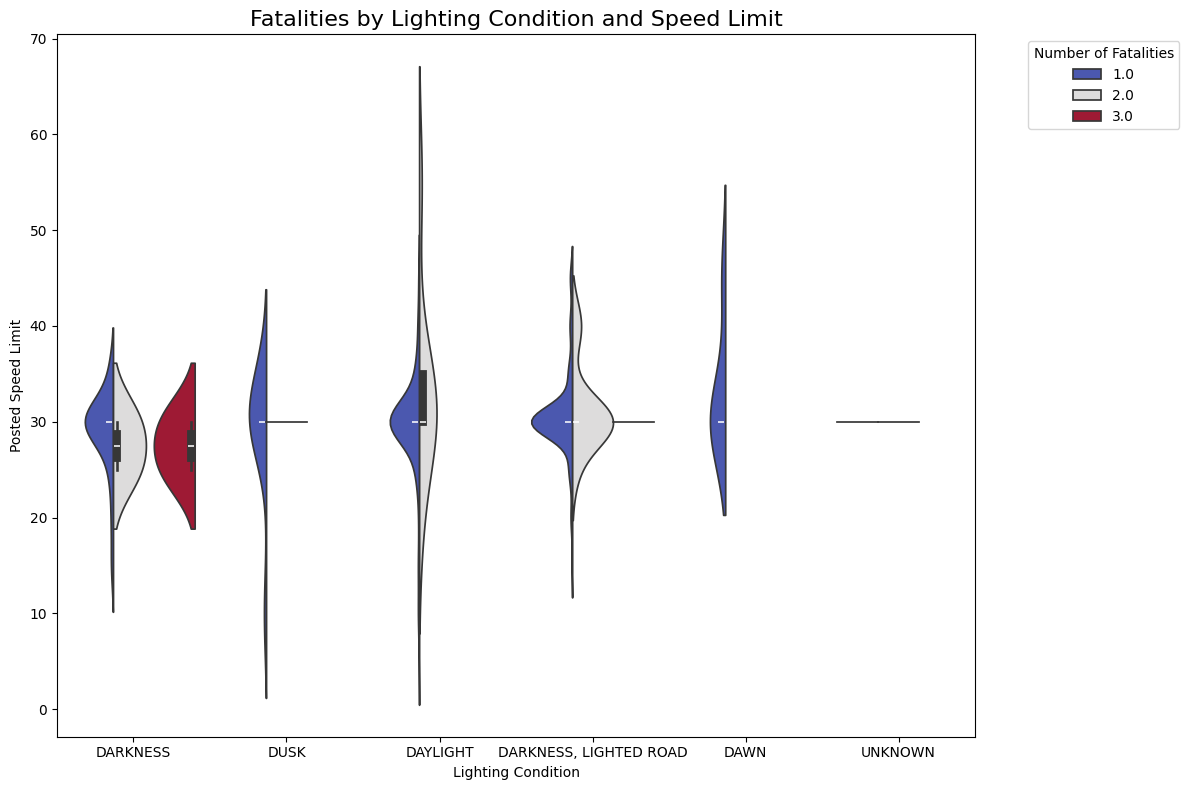

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=fatal_crashes,
    x='lighting_condition',
    y='posted_speed_limit',
    hue='injuries_fatal',
    split=True,
    palette='coolwarm'
)
plt.title('Fatalities by Lighting Condition and Speed Limit', fontsize=16)
plt.xlabel('Lighting Condition')
plt.ylabel('Posted Speed Limit')
plt.legend(title='Number of Fatalities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-48-3609f69a0a68>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




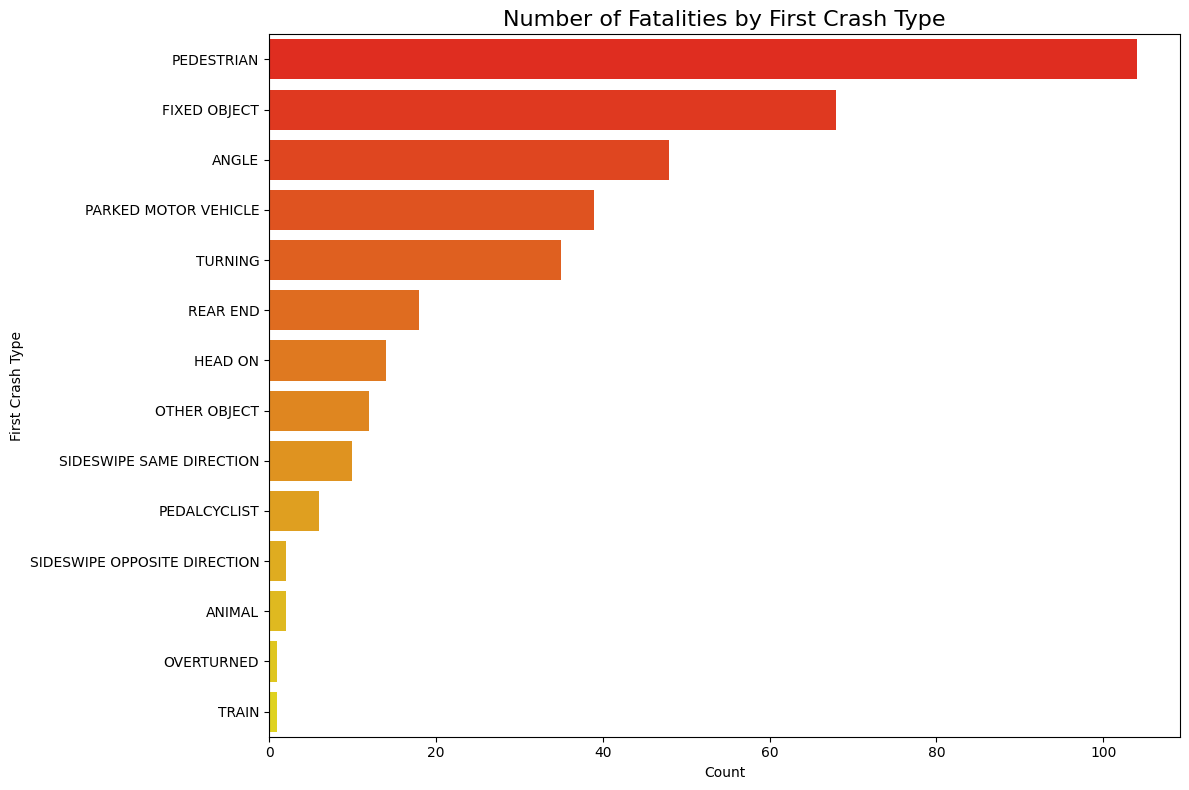

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=fatal_crashes,
    y='first_crash_type',
    order=fatal_crashes['first_crash_type'].value_counts().index,
    palette='autumn'
)
plt.title('Number of Fatalities by First Crash Type', fontsize=16)
plt.xlabel('Count')
plt.ylabel('First Crash Type')
plt.tight_layout()
plt.show()

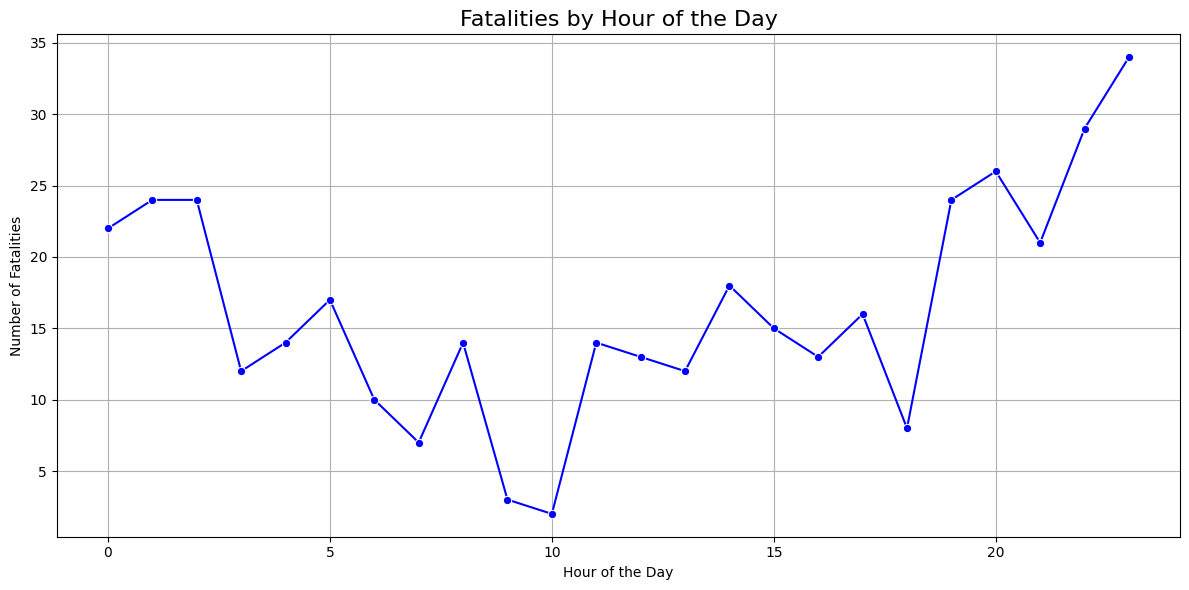

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_fatal, x='crash_hour', y='injuries_fatal', marker='o', color='blue')
plt.title('Fatalities by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fatalities')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-38-9b9b03cfe875>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




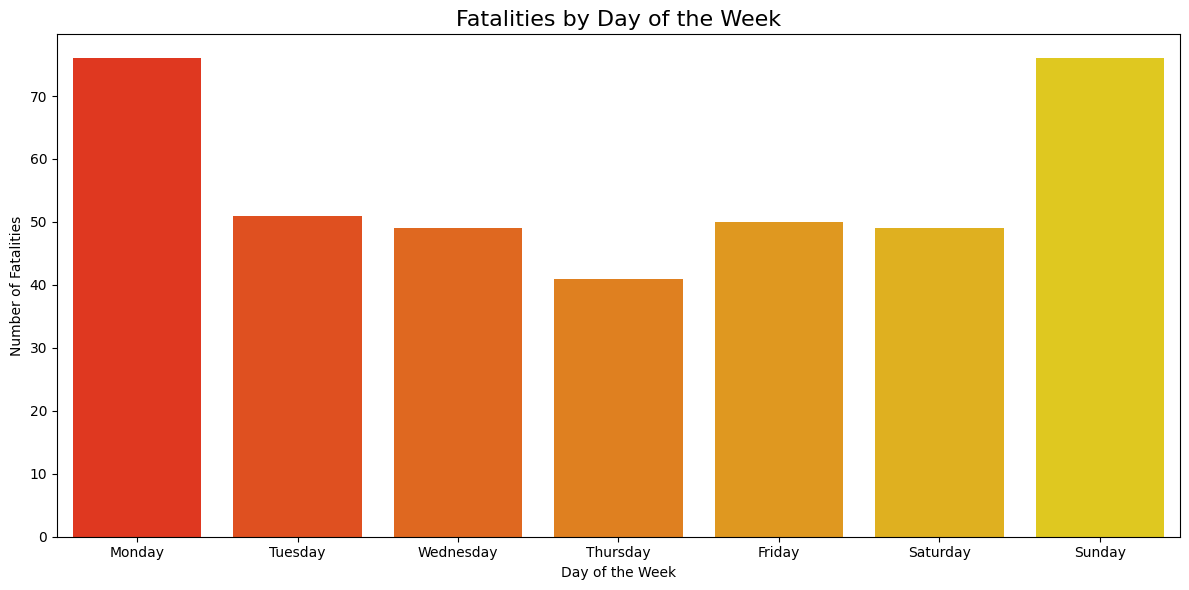

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=day_of_week_fatal, x='crash_day_of_week', y='injuries_fatal', palette='autumn')
plt.title('Fatalities by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fatalities')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

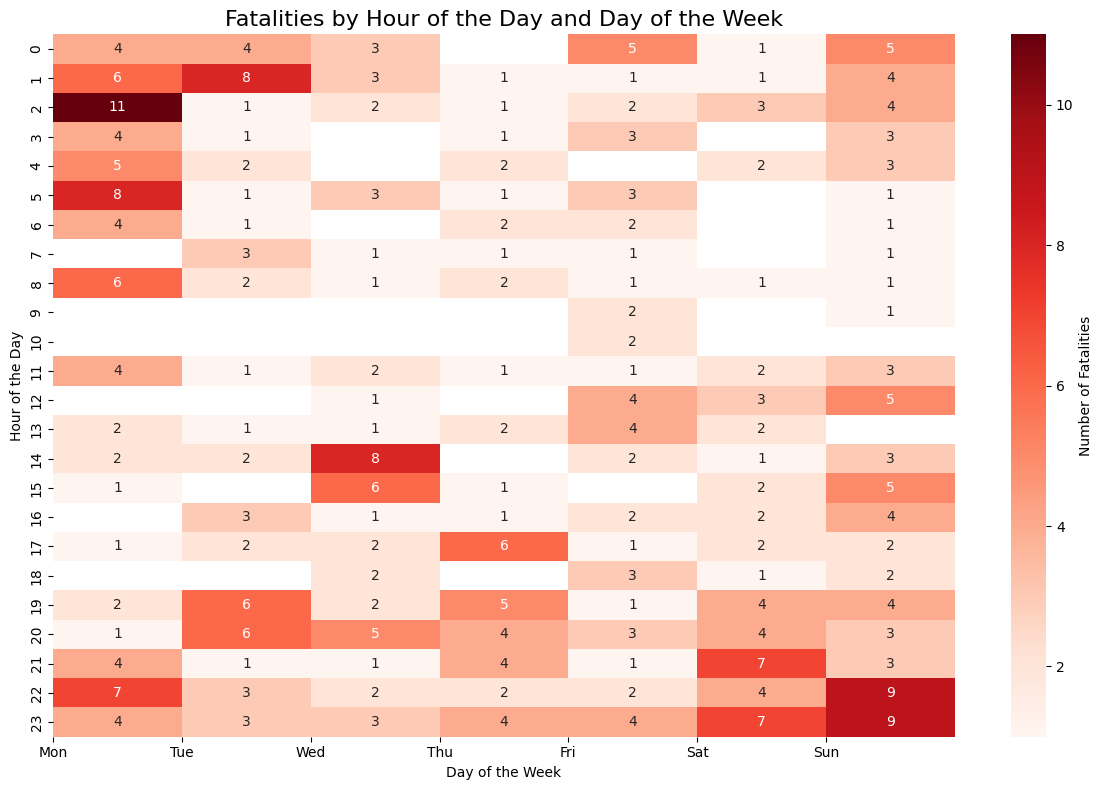

In [ ]:
# Lọc dữ liệu chỉ giữ lại các trường hợp có tử vong
fatal_crashes = crashes[crashes['injuries_fatal'] > 0]

# Tổng hợp dữ liệu: Tử vong theo giờ và ngày trong tuần
hour_day_fatal = fatal_crashes.groupby(['crash_hour', 'crash_day_of_week'])['injuries_fatal'].sum().reset_index()

# Pivot table để tạo dữ liệu cho heatmap
hour_day_pivot = hour_day_fatal.pivot(index='crash_hour', columns='crash_day_of_week', values='injuries_fatal')

# Vẽ heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_pivot, annot=True, fmt=".0f", cmap='Reds', cbar_kws={'label': 'Number of Fatalities'})

# Thêm tiêu đề và nhãn
plt.title('Fatalities by Hour of the Day and Day of the Week', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

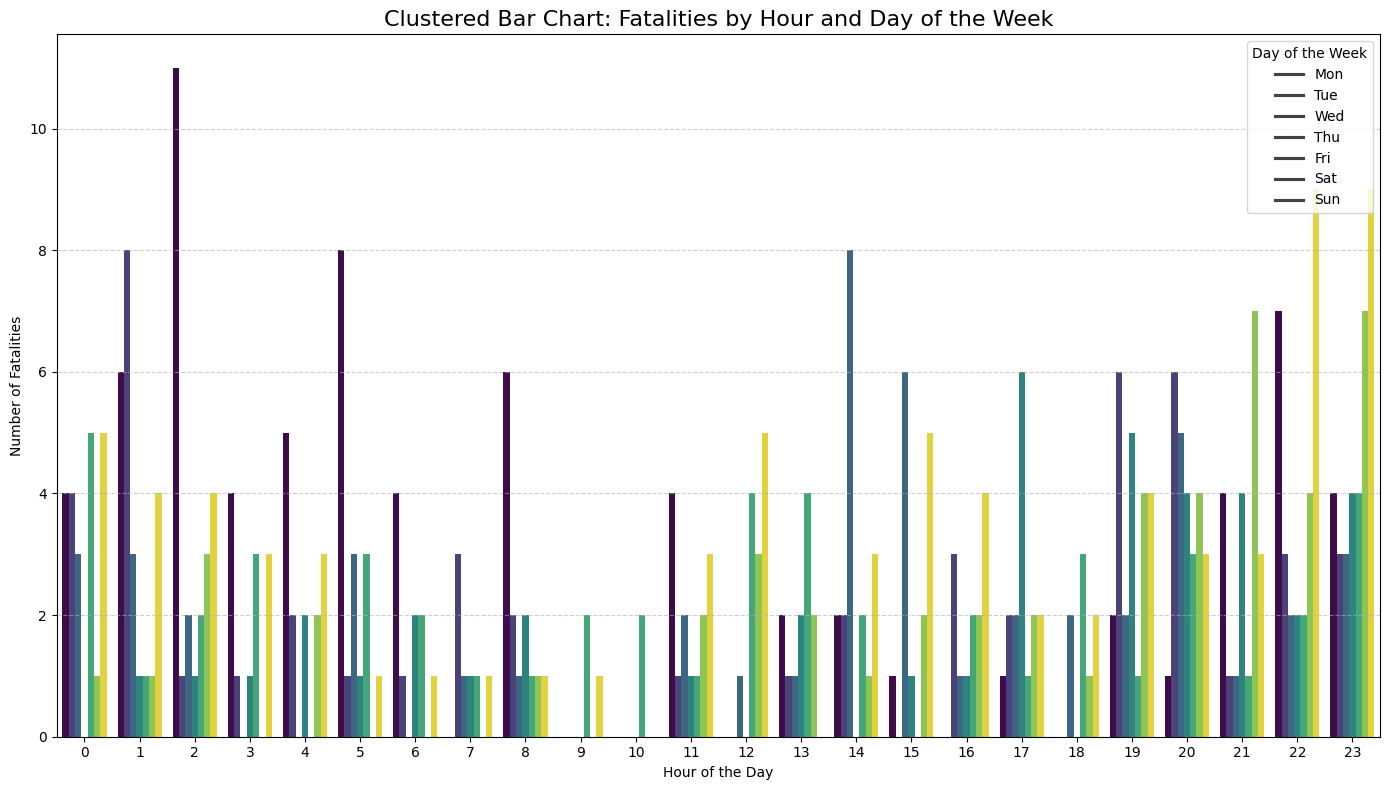

In [ ]:
# Lọc dữ liệu
fatal_crashes = crashes[crashes['injuries_fatal'] > 0]
hour_day_fatal = fatal_crashes.groupby(['crash_hour', 'crash_day_of_week'])['injuries_fatal'].sum().reset_index()

# Vẽ biểu đồ thanh nhóm
plt.figure(figsize=(14, 8))
sns.barplot(
    data=hour_day_fatal,
    x='crash_hour',
    y='injuries_fatal',
    hue='crash_day_of_week',
    palette='viridis'
)

# Tùy chỉnh
plt.title('Clustered Bar Chart: Fatalities by Hour and Day of the Week', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fatalities')
plt.legend(title='Day of the Week', labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

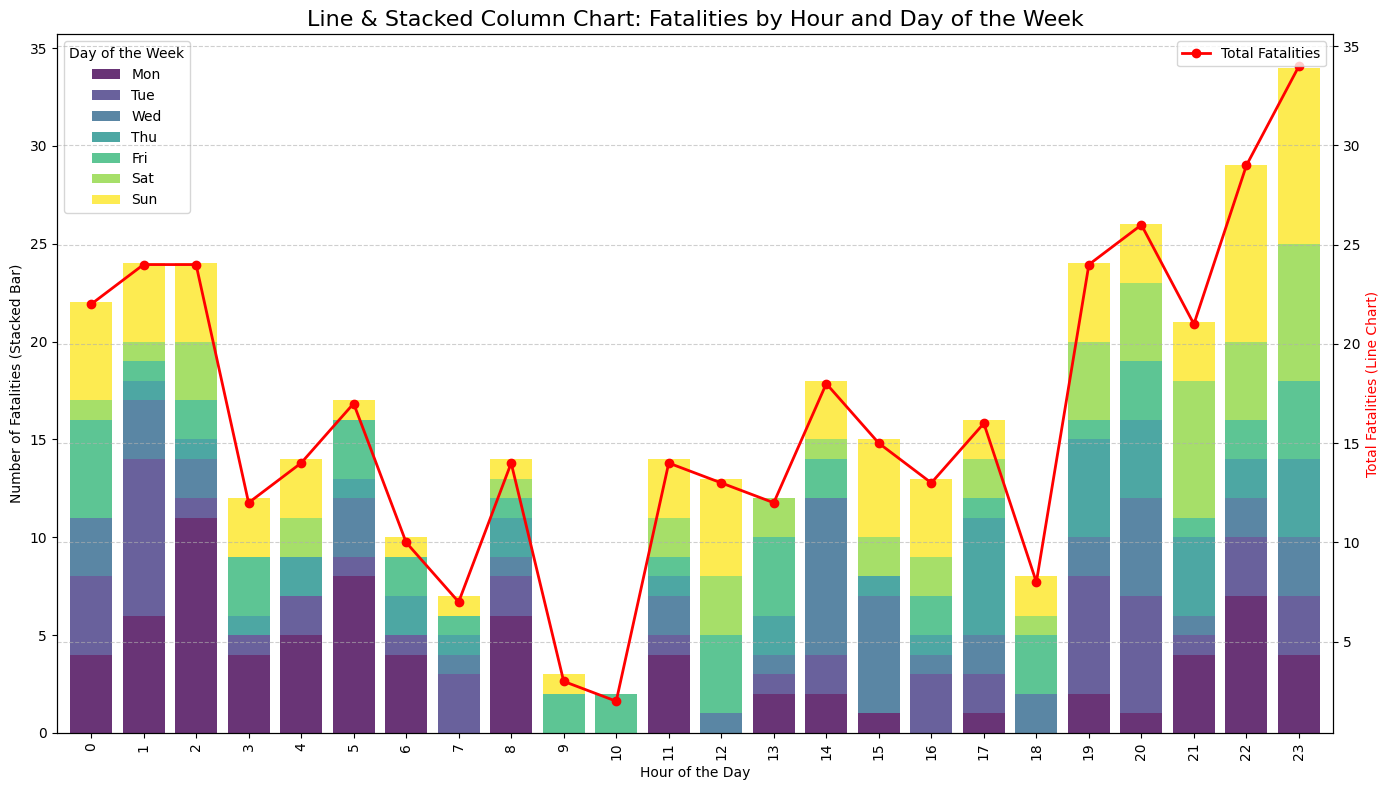

In [ ]:
# Tạo bảng pivot để sử dụng cho stacked column
hour_day_pivot = hour_day_fatal.pivot(index='crash_hour', columns='crash_day_of_week', values='injuries_fatal').fillna(0)

# Tổng hợp tổng số tử vong theo giờ trong ngày
total_fatalities_by_hour = hour_day_pivot.sum(axis=1)

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 8))

# Vẽ stacked bar chart
hour_day_pivot.plot(kind='bar', stacked=True, colormap='viridis', ax=ax1, alpha=0.8, width=0.8)

# Thêm line chart
ax2 = ax1.twinx()
ax2.plot(total_fatalities_by_hour.index, total_fatalities_by_hour.values, color='red', marker='o', linewidth=2, label='Total Fatalities')

# Tùy chỉnh trục và tiêu đề
ax1.set_title('Line & Stacked Column Chart: Fatalities by Hour and Day of the Week', fontsize=16)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Fatalities (Stacked Bar)')
ax2.set_ylabel('Total Fatalities (Line Chart)', color='red')
ax1.legend(title='Day of the Week', labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], loc='upper left')
ax2.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

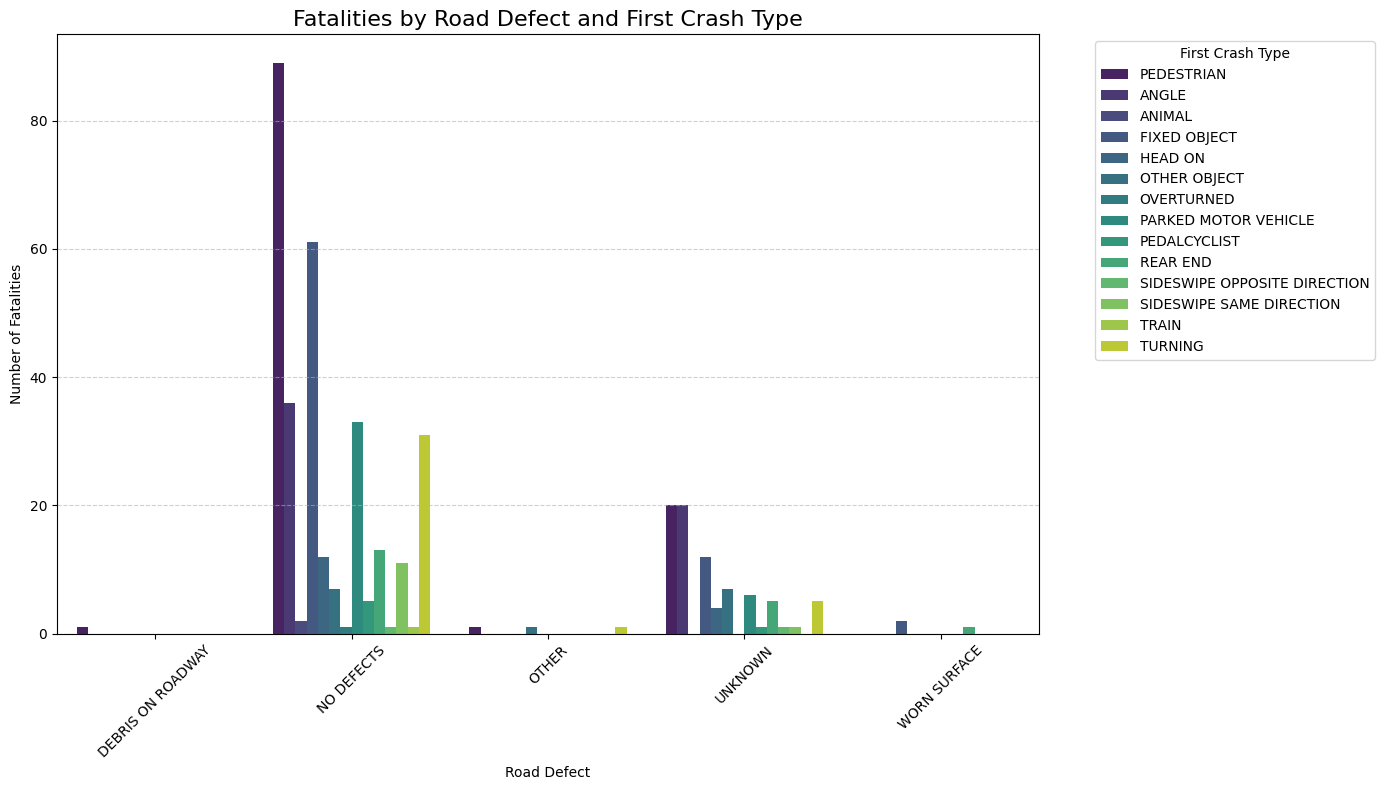

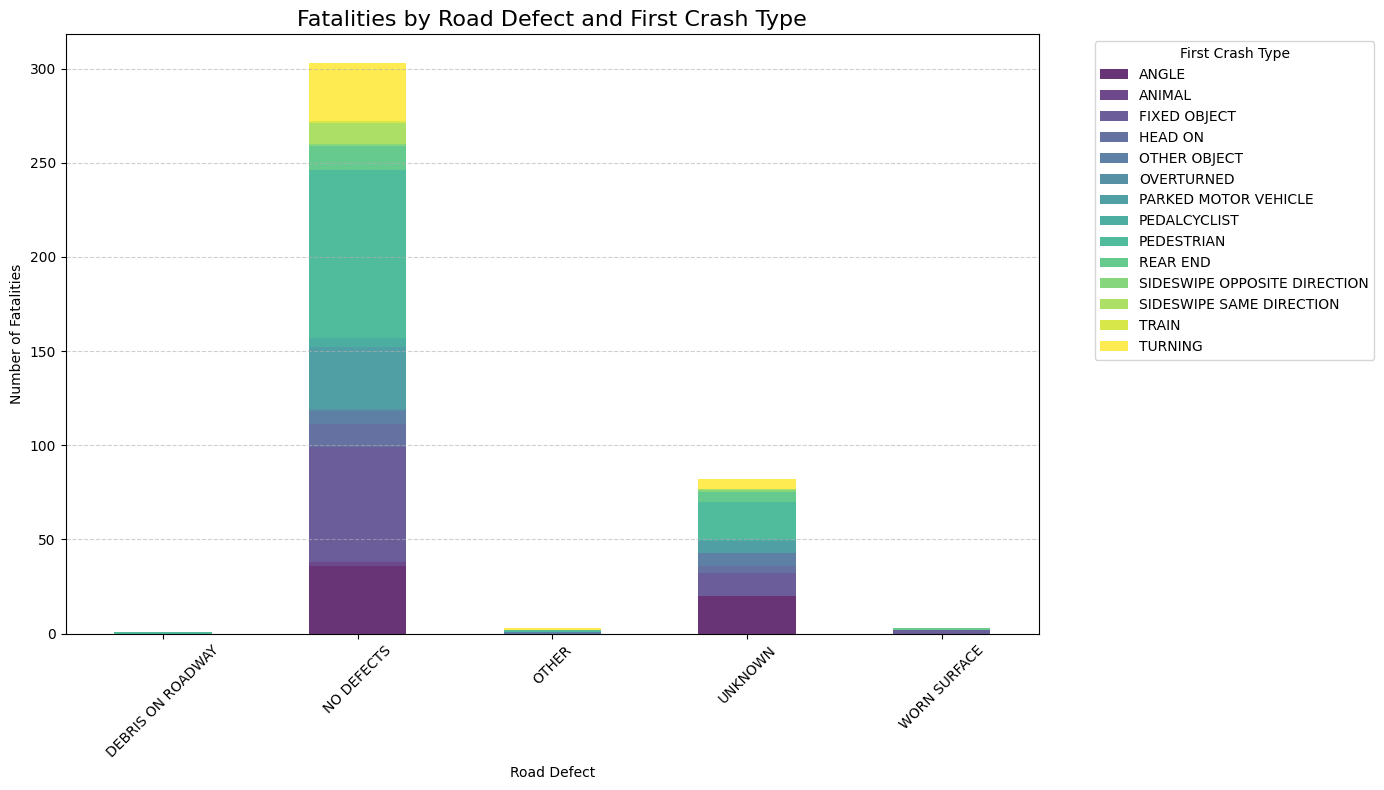

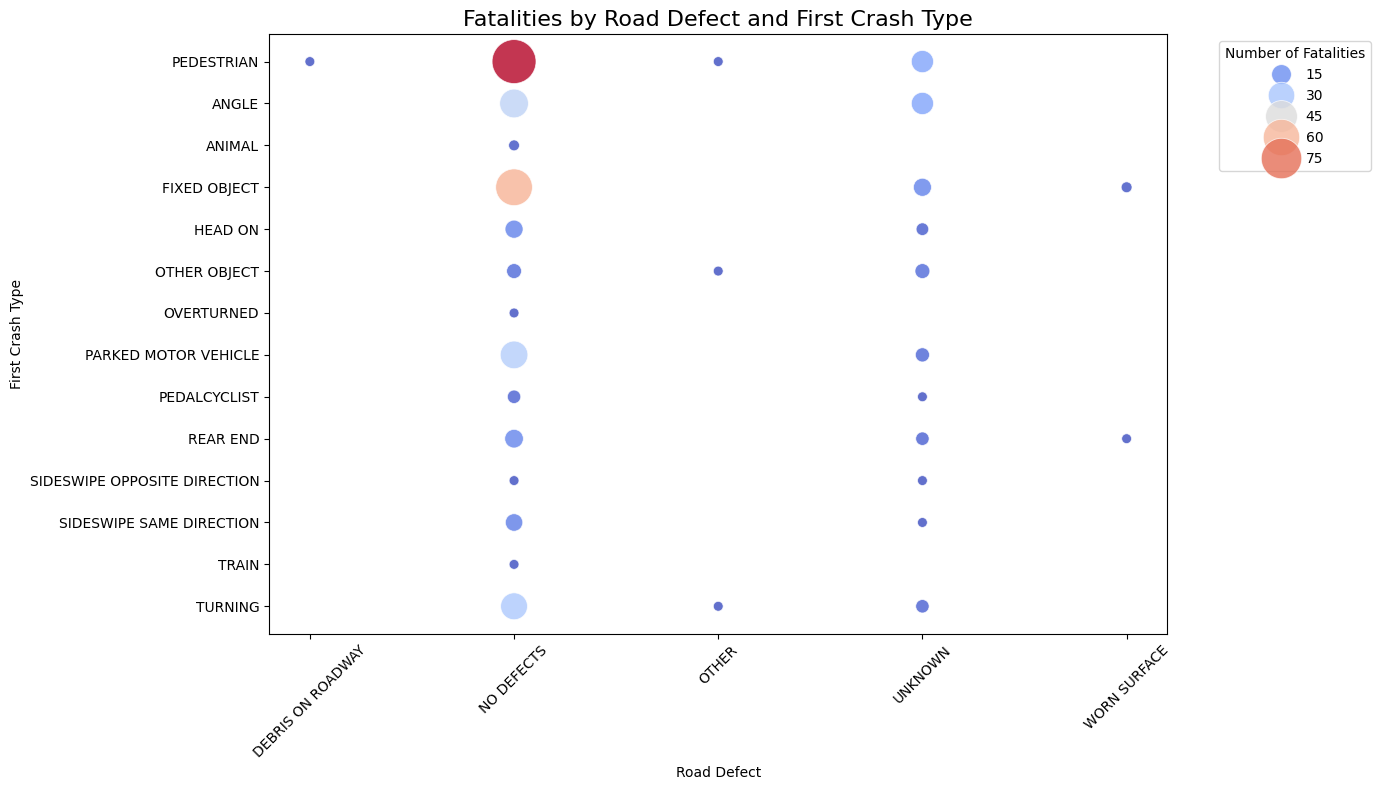

In [ ]:
fatal_crashes = crashes[crashes['injuries_fatal'] > 0]

# Tổng hợp dữ liệu: Tử vong theo lỗi mặt đường và loại tai nạn đầu tiên
road_defect_crash_type_fatal = (
    fatal_crashes.groupby(['road_defect', 'first_crash_type'])['injuries_fatal']
    .sum()
    .reset_index()
)
plt.figure(figsize=(14, 8))
sns.barplot(
    data=road_defect_crash_type_fatal,
    x='road_defect',
    y='injuries_fatal',
    hue='first_crash_type',
    palette='viridis'
)

# Tùy chỉnh
plt.title('Fatalities by Road Defect and First Crash Type', fontsize=16)
plt.xlabel('Road Defect')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=45)
plt.legend(title='First Crash Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Tạo bảng pivot để sử dụng cho stacked bar chart
road_defect_pivot = road_defect_crash_type_fatal.pivot(
    index='road_defect', columns='first_crash_type', values='injuries_fatal'
).fillna(0)

# Vẽ biểu đồ Stacked Bar Chart
road_defect_pivot.plot(
    kind='bar', stacked=True, colormap='viridis', figsize=(14, 8), alpha=0.8
)

# Tùy chỉnh
plt.title('Fatalities by Road Defect and First Crash Type', fontsize=16)
plt.xlabel('Road Defect')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=45)
plt.legend(title='First Crash Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=road_defect_crash_type_fatal,
    x='road_defect',
    y='first_crash_type',
    size='injuries_fatal',
    hue='injuries_fatal',
    sizes=(50, 1000),
    palette='coolwarm',
    alpha=0.8
)

# Tùy chỉnh
plt.title('Fatalities by Road Defect and First Crash Type', fontsize=16)
plt.xlabel('Road Defect')
plt.ylabel('First Crash Type')
plt.xticks(rotation=45)
plt.legend(title='Number of Fatalities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Filter data to include only rows with fatalities
fatalities_df = crashes[crashes["injuries_fatal"] > 0]

# Aggregating data for analysis
fatal_analysis_df = (
    fatalities_df.groupby(["trafficway_type", "posted_speed_limit", "weather_condition", "most_severe_injury"])
    .agg(total_fatalities=("injuries_fatal", "sum"), count=("injuries_fatal", "size"))
    .reset_index()
    .sort_values(by="total_fatalities", ascending=False)
)


# Bar chart: Fatalities by trafficway type and speed limit
fig_bar = px.bar(
    fatal_analysis_df.groupby(["trafficway_type", "posted_speed_limit"])
    .agg(total_fatalities=("total_fatalities", "sum"))
    .reset_index(),
    x="trafficway_type",
    y="total_fatalities",
    color="posted_speed_limit",
    title="Fatalities by Trafficway Type and Speed Limit",
    labels={
        "trafficway_type": "Trafficway Type",
        "total_fatalities": "Number of Fatalities",
        "posted_speed_limit": "Speed Limit (mph)",
    },
    barmode="group",
)

fig_bar.show()



In [ ]:
crashes['prim_contributory_cause'].value_counts()

,count
prim_contributory_cause,
UNABLE TO DETERMINE,126378
FAILING TO YIELD RIGHT-OF-WAY,33764
FOLLOWING TOO CLOSELY,25570
IMPROPER OVERTAKING/PASSING,16103
NOT APPLICABLE,15717
FAILING TO REDUCE SPEED TO AVOID CRASH,11972
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,11445
IMPROPER TURNING/NO SIGNAL,10332
IMPROPER BACKING,9716


## Ảnh Hưởng của Tình Trạng Thiết Bị Giao Thông
**Kịch bản:** So sánh DEVICE_CONDITION (Tình trạng thiết bị) với TRAFFIC_CONTROL_DEVICE (Thiết bị điều khiển giao thông) để đánh giá tác động của các thiết bị hỏng hóc lên khả năng xảy ra tai nạn.

**Thông tin rút ra:** Hướng dẫn phân bổ tài nguyên để bảo trì.

In [ ]:
# Aggregating data for analysis
device_condition_analysis_df = (
    crashes.groupby(["device_condition", "traffic_control_device"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

# Simplify categories for better visualization
threshold = 200  # Combine smaller categories
device_condition_analysis_df["traffic_control_device"] = device_condition_analysis_df["traffic_control_device"].apply(
    lambda x: x if device_condition_analysis_df[device_condition_analysis_df["traffic_control_device"] == x]["count"].sum() > threshold else "Others"
)

# Bar chart: Crash count by device condition and traffic control device
fig_bar = px.bar(
    device_condition_analysis_df,
    x="device_condition",
    y="count",
    color="traffic_control_device",
    barmode="group",
    title="Impact of Device Condition on Traffic Control Devices",
    labels={
        "device_condition": "Device Condition",
        "count": "Number of Crashes",
        "traffic_control_device": "Traffic Control Device",
    },
)

fig_bar.show()

# Treemap: Device condition and traffic control devices
fig_treemap = px.treemap(
    device_condition_analysis_df,
    path=["device_condition", "traffic_control_device"],
    values="count",
    title="Impact of Device Condition on Traffic Control Devices",
    color="count",
    color_continuous_scale="viridis",
    hover_data={"count": True},
)

fig_treemap.show()